## Dimension reduction with bias correction 

### In this notebook, we will show how to perform traditional dimension reduction methods on datasets with missing observations using the bias correction.

In [2]:
# Ignore this cell if the corresponding packages are already installed

#!pip install fancyimpute

In [1]:
import matplotlib.cm as cm
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer

from fancyimpute import SoftImpute,BiScaler

from generate_data_and_missingness import *
from bias_correction import *

import matplotlib.pyplot as plt
%matplotlib inline

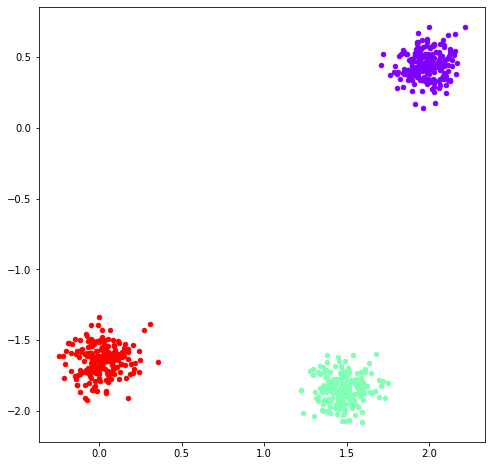

In [3]:
## Simulate data in a PPCA setting with the ground-truth low-dimension k=2

random_seed = 345
np.random.seed(random_seed)
n_clusters = 3 #number of clusters to be simulated
n = 600
d = 3000
k = 2 
sigma = 2.
X,Z,cluster_ids = generate_simulated_data(n_clusters, n, d, k, sigma) 


f, ax = plt.subplots(1,1, figsize=(8,8))
point_size = 20
title_size = 20
colors = cm.rainbow(np.linspace(0, 1,n_clusters))

for i, c in zip(np.arange(n_clusters), colors):
    idx_labels = (cluster_ids == i)
    ax.scatter(Z[idx_labels,0], Z[idx_labels,1], color=c, label=i, s=point_size)

In [4]:
## Generate missing observations
np.random.seed(random_seed)
X_miss = generate_missing_observations(X, method='uniform', low_i=0.4, high_i=0.6, low_j=0.7, high_j = 0.9)

mask = np.isnan(X_miss)
M = np.ones_like(X)
M[mask] = 0 #set missing observations to 0 for the proposed bias correction

Y = np.copy(X)
Y[mask] = 0


Fraction of missing data: 0.397


In [ ]:
n_gene = [500,1000,2000,X.shape[1]] # sizes of sampled features
latent_dim = 2

gene_iter_n = len(n_gene)


# create arrays to store the ARI and low-dimensional components obtained from k-means clustering results
# prefix BC stands for bias-corrected variant; soft represents softImpute
PCA_complete_KMeans =  np.zeros((gene_iter_n, ))
PCA_KMeans = np.zeros((gene_iter_n, ))
BC_PCA_KMeans = np.zeros((gene_iter_n, ))
soft_PCA_KMeans = np.zeros((gene_iter_n,))
ice_PCA_KMeans = np.zeros((gene_iter_n,))

PCA_complete_x = np.zeros((gene_iter_n, n,2))
PCA_x = np.zeros((gene_iter_n, n,2))
BC_PCA_x = np.zeros((gene_iter_n,n, 2))
soft_PCA_x = np.zeros((gene_iter_n,n, 2))
ice_PCA_x = np.zeros((gene_iter_n,n, 2))


for i in range(gene_iter_n):
    idx = np.random.choice(d, size =  n_gene[i], replace=False)
        
    PCA_complete_x[i,:,:] = mdsReduce(X[:,idx],latent_dim) # PCA on the complete dataset
    PCA_x[i,:,:] = mdsReduce(Y[:,idx],latent_dim) # PCA on the incomplete dataset
    BC_PCA_x[i,:,:] = BC_mdsReduce(Y[:,idx],M[:,idx] ,latent_dim) #BC-PCA on the incomplete dataset

    PCA_complete_KMeans[i] = get_ARI(PCA_complete_x[i,:,:], cluster_ids, n_cluster=n_clusters, method="KMeans")
    PCA_KMeans[i] = get_ARI(PCA_x[i,:,:], cluster_ids, n_cluster=n_clusters, method="KMeans")
    BC_PCA_KMeans[i] = get_ARI(BC_PCA_x[i,:,:], cluster_ids, n_cluster=n_clusters, method="KMeans")


    X_miss_normalised = BiScaler(verbose=False).fit_transform(X_miss[:,idx])
    soft_imp = SoftImpute(verbose=False).fit_transform(X_miss_normalised) # imputed data matrix obtained by SoftImpute
    soft_PCA_x[i,:,:] = mdsReduce(soft_imp,latent_dim)
    soft_PCA_KMeans[i] = get_ARI(soft_PCA_x[i,:,:], cluster_ids, n_cluster=n_clusters, method="KMeans")

    ice_imp = IterativeImputer(max_iter=50,n_nearest_features = 10).fit_transform(X_miss[:,idx])# imputed data matrix obtained by ice
    ice_PCA_x[i,:,:] = mdsReduce(ice_imp,latent_dim)
    ice_PCA_KMeans[i] = get_ARI(ice_PCA_x[i,:,:], cluster_ids, n_cluster=n_clusters, method="KMeans")



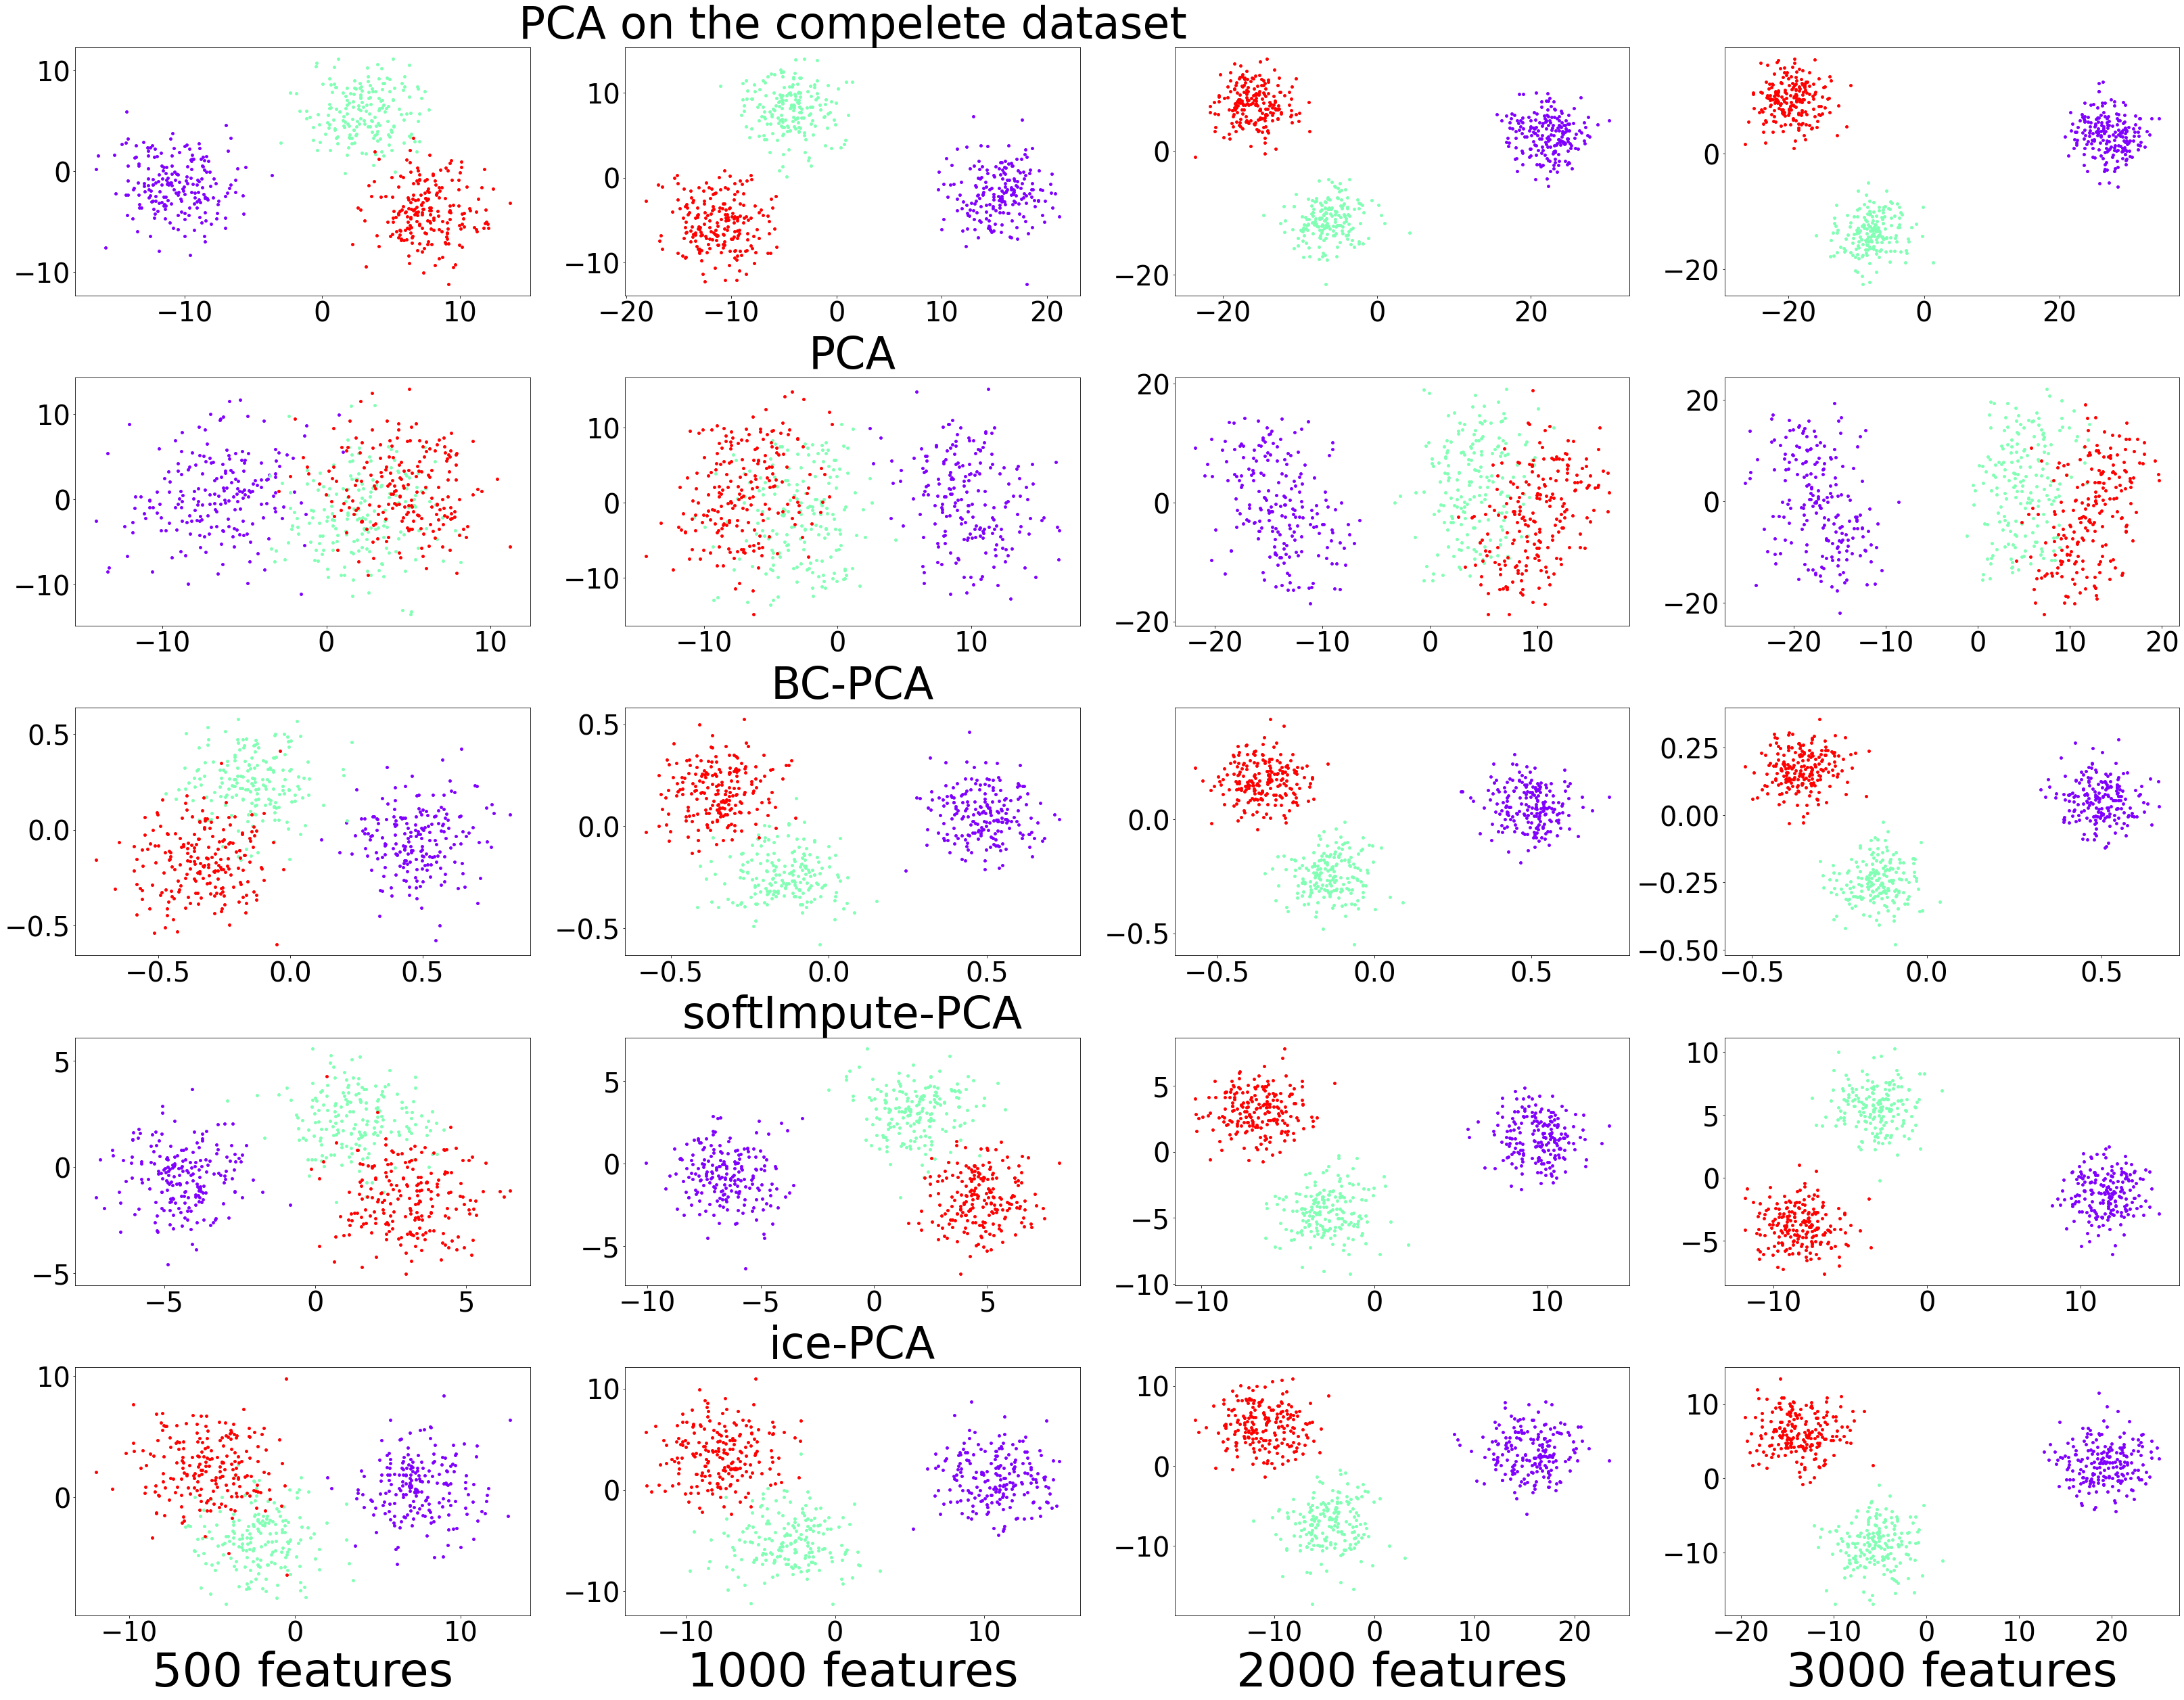

In [8]:
#Visualisation results with different size of features
f, ax = plt.subplots(5,gene_iter_n, figsize=(45,35))

point_size=15
colors = cm.rainbow(np.linspace(0, 1,n_clusters))
title_size = 65

for tt in range(gene_iter_n):
    ax[4][tt].set_xlabel(str(n_gene[tt]) + ' features',fontsize=70 )
    for i, c in zip(np.arange(n_clusters), colors):
        idx_labels = (cluster_ids == i)
        ax[0][tt].scatter(PCA_complete_x[tt, idx_labels,0], PCA_complete_x[tt, idx_labels,1], color=c, label=i, s=point_size)
        ax[1][tt].scatter(PCA_x[tt, idx_labels,0], PCA_x[tt, idx_labels,1], color=c, label=i, s=point_size)
        ax[2][tt].scatter(BC_PCA_x[tt, idx_labels,0], BC_PCA_x[tt, idx_labels,1], color=c, label=i, s=point_size)
        ax[3][tt].scatter(soft_PCA_x[tt, idx_labels,0], soft_PCA_x[tt, idx_labels,1], color=c, label=i, s=point_size)
        ax[4][tt].scatter(ice_PCA_x[tt, idx_labels,0], ice_PCA_x[tt, idx_labels,1], color=c, label=i, s=point_size)

for tt in range(gene_iter_n):
    for i in range(5):
        ax[i][tt].tick_params(axis='both', which='major', labelsize=40)

loc = int(np.median(np.arange(gene_iter_n)))
ax[0][loc].set_title('PCA on the compelete dataset', {'fontsize':title_size})
ax[1][loc].set_title('PCA', {'fontsize':title_size})
ax[2][loc].set_title('BC-PCA', {'fontsize':title_size})
ax[3][loc].set_title('softImpute-PCA', {'fontsize':title_size})
ax[4][loc].set_title('ice-PCA', {'fontsize':title_size})
f.tight_layout(pad=1.03)



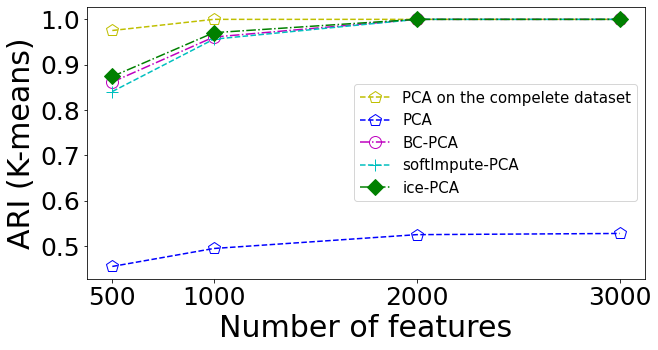

In [15]:
#Plots of k-means results
plt.figure(figsize=(10,5)) 

markersize=12

plt.plot(n_gene, PCA_complete_KMeans, c='y',marker="p",ls='--',\
             label='PCA on the compelete dataset',fillstyle='none', markersize=markersize)
plt.plot(n_gene,PCA_KMeans, c='b',marker="p",ls='--',\
             label='PCA',fillstyle='none', markersize=markersize)
plt.plot(n_gene, BC_PCA_KMeans, c='m',marker="o",ls='-.',\
             label='BC-PCA',fillstyle='none', markersize=markersize)
plt.plot(n_gene, soft_PCA_KMeans, c='c',marker="+",ls='--',\
             label='softImpute-PCA', markersize=markersize)
plt.plot(n_gene, ice_PCA_KMeans,c='g',marker="D",\
             ls='-.',label='ice-PCA', markersize=markersize)


plt.xlabel('Number of features', fontsize=30)
plt.ylabel('ARI (K-means)', fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xticks(n_gene, n_gene)
plt.legend(loc='best', prop={'size': 15}, ncol=1)

plt.show()